# News Credibility Classification

## BharatFakeNewsKosh Dataset

This notebook implements a **machine learning pipeline** that classifies news articles as **Fake (1)** or **Real (0)** using classical NLP (TF-IDF) and interpretable classifiers.

---

## Document Structure

| Section | Description |
|--------|-------------|
| **Title** | Project and dataset overview |
| **Problem Statement** | Real-world context of misinformation |
| **Objective** | Goals and success criteria |
| **Dataset Description** | BharatFakeNewsKosh schema and statistics |
| **Methodology** | Preprocessing, features, models, evaluation |
| **Implementation** | Step-by-step code and pipeline |
| **Results** | Metrics, confusion matrices, model comparison |
| **Conclusion** | Interpretation and implications |

---

## Problem Statement

**Misinformation and fake news** spread rapidly on social media and messaging platforms, affecting public opinion, health, and trust in institutions. Manual fact-checking does not scale. Automated **news credibility classification** helps prioritize content for human review and supports users in assessing reliability.

This project addresses **binary classification**: given a news article or claim (and optionally its body), predict whether it is **Fake (misinformation)** or **Real (credible)**. The model is trained on fact-checked labels from the BharatFakeNewsKosh dataset.

---

## Objective

- **Primary:** Build a reproducible ML pipeline that classifies news as Fake vs Real with strong precision, recall, and F1.
- **Secondary:** Use interpretable models (Logistic Regression, Decision Tree) and TF-IDF features for transparency.
- **Constraints:** Same preprocessing must be used at training and inference (e.g. in the Streamlit app).

---

## Dataset Description

**BharatFakeNewsKosh** is a collection of Indian news articles with fact-check labels. Key columns:

- **Eng_Trans_Statement** — English translation of the headline/claim
- **Eng_Trans_News_Body** — English translation of the article body
- **Label** — Boolean: `True` = Fake, `False` = Real
- **Language**, **News_Category**, **Region**, **Platform** — metadata for analysis

The combined text (statement + body) is used as input to the classifier. Labels are converted to numeric: Fake = 1, Real = 0.

---

## Methodology

1. **Preprocessing:** Lowercasing, URL/mention removal, keep letters only, tokenization, NLTK stopword removal and WordNet lemmatization.
2. **Features:** TF-IDF on unigrams and bigrams (configurable `max_features`, `min_df`, `max_df`).
3. **Models:** Logistic Regression and Decision Tree in sklearn `Pipeline` with `class_weight='balanced'` to handle class imbalance.
4. **Evaluation:** Stratified train/test split, classification report (precision, recall, F1), ROC-AUC, confusion matrices, 5-fold cross-validation, and model comparison table.

---
## Implementation

### Step 1: Install & Import Libraries

**What:** Install dependencies and import pandas, numpy, matplotlib, seaborn, NLTK (stopwords, WordNetLemmatizer), sklearn (TfidfVectorizer, LogisticRegression, DecisionTreeClassifier, Pipeline, train_test_split, cross_val_score, metrics), and joblib.

**Why:** A single environment ensures reproducibility. NLTK resources are required for the same preprocessing used at inference.

**ML reasoning:** Using a `Pipeline` keeps vectorizer and classifier coupled so we never leak test data into the vectorizer.

In [ ]:
!pip install scikit-learn pandas numpy matplotlib seaborn nltk joblib openpyxl wordcloud -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, roc_curve,
    precision_recall_curve
)
import joblib

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


### Step 2: Load Dataset

**What:** Load the BharatFakeNewsKosh Excel file and inspect shape and columns.

**Why:** Confirms the dataset path and schema before preprocessing. We need `Eng_Trans_Statement`, `Eng_Trans_News_Body`, and `Label`.

**Alternative:** Load from CSV or a database; ensure column names match.

In [3]:
df = pd.read_excel('bharatfakenewskosh.xlsx')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head(3)

Dataset Shape: (26232, 19)

Columns: ['id', 'Author_Name', 'Fact_Check_Source', 'Source_Type', 'Statement', 'Eng_Trans_Statement', 'News Body', 'Eng_Trans_News_Body', 'Media_Link', 'Publish_Date', 'Fact_Check_Link', 'News_Category', 'Language', 'Region', 'Platform', 'Text', 'Video', 'Image', 'Label']


,id,Author_Name,Fact_Check_Source,Source_Type,Statement,Eng_Trans_Statement,News Body,Eng_Trans_News_Body,Media_Link,Publish_Date,Fact_Check_Link,News_Category,Language,Region,Platform,Text,Video,Image,Label
0,BFNK_1,Shinjinee Majumder,Alt News,IFCN,फ़ैक्ट-चेक: तेलंगाना में एक रिपोर्टर ने गृह मंत...,Fact-check: A reporter in Telangana stopped sp...,सोशल मीडिया पर एक वीडियो वायरल है जिसमें एक पत...,A video is viral on social media in which a jo...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,9th July 2022,https://www.altnews.in/Hindi/fact-check-was-am...,Politics,Hindi,Telangana,Twitter,no,yes,no,False
1,BFNK_2,Kalim Ahmed,Alt News,IFCN,PM मोदी को UAE का सर्वोच्च नागरिक सम्मान मिलने...,Share by stating the old video of PM Modi's hi...,प्रधानमंत्री नरेंद्र मोदी को सोने की चेन से सम...,A video of Prime Minister Narendra Modi being ...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,9th July 2022,https://www.altnews.in/Hindi/old-video-of-pm-m...,Politics,Hindi,National,Twitter,no,yes,no,False
2,BFNK_3,Abhishek Kumar,Alt News,IFCN,वायरल तस्वीर में सुप्रीम कोर्ट के जज सूर्यकांत...,Supreme Court judges Suryakant and JB Pardiwal...,बीते दिनों नूपुर शर्मा ने टीवी डिबेट में पैगम्...,"Recently, Nupur Sharma made an objectionable c...",https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,7th July 2022,https://www.altnews.in/Hindi/false-claim-with-...,Politics,Hindi,National,Twitter,no,no,yes,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26232 entries, 0 to 26231
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   26232 non-null  object
 1   Author_Name          26005 non-null  object
 2   Fact_Check_Source    26232 non-null  object
 3   Source_Type          26232 non-null  object
 4   Statement            26232 non-null  object
 5   Eng_Trans_Statement  26232 non-null  object
 6   News Body            25359 non-null  object
 7   Eng_Trans_News_Body  25360 non-null  object
 8   Media_Link           24489 non-null  object
 9   Publish_Date         25417 non-null  object
 10  Fact_Check_Link      24302 non-null  object
 11  News_Category        26216 non-null  object
 12  Language             26232 non-null  object
 13  Region               25525 non-null  object
 14  Platform             26232 non-null  object
 15  Text                 26232 non-null  object
 16  Vide

In [5]:
print("Null values per column:")
print(df.isnull().sum())

Null values per column:
id                        0
Author_Name             227
Fact_Check_Source         0
Source_Type               0
Statement                 0
Eng_Trans_Statement       0
News Body               873
Eng_Trans_News_Body     872
Media_Link             1743
Publish_Date            815
Fact_Check_Link        1930
News_Category            16
Language                  0
Region                  707
Platform                  0
Text                      0
Video                     0
Image                     0
Label                     0
dtype: int64


### Step 3: Exploratory Data Analysis (EDA)

**What:** Visualize label distribution (Fake vs Real), top languages, top news categories, and text length distributions by label.

**Why:** Informs preprocessing and highlights class balance; we use `class_weight='balanced'` if classes are imbalanced. Length distributions can reveal need for truncation or padding (we use full text with TF-IDF).

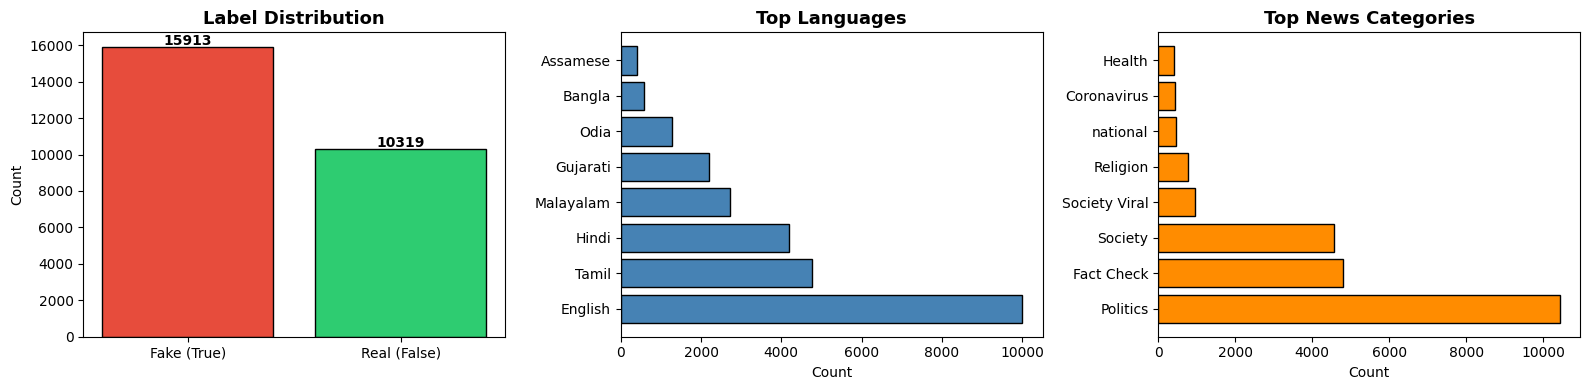

Fake articles: 15913 | Real articles: 10319


In [ ]:
import os
os.makedirs('plots', exist_ok=True)

label_counts = df['Label'].value_counts()
label_names = {True: 'Fake (True)', False: 'Real (False)'}

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].bar([label_names[k] for k in label_counts.index], label_counts.values,
            color=['#e74c3c', '#2ecc71'], edgecolor='black')
axes[0].set_title('Label Distribution', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

lang_counts = df['Language'].value_counts().head(8)
axes[1].barh(lang_counts.index, lang_counts.values, color='steelblue', edgecolor='black')
axes[1].set_title('Top Languages', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Count')

cat_counts = df['News_Category'].value_counts().head(8)
axes[2].barh(cat_counts.index, cat_counts.values, color='darkorange', edgecolor='black')
axes[2].set_title('Top News Categories', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Count')

plt.tight_layout()
plt.savefig('plots/eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("Fake articles:", label_counts[True], "| Real articles:", label_counts[False])

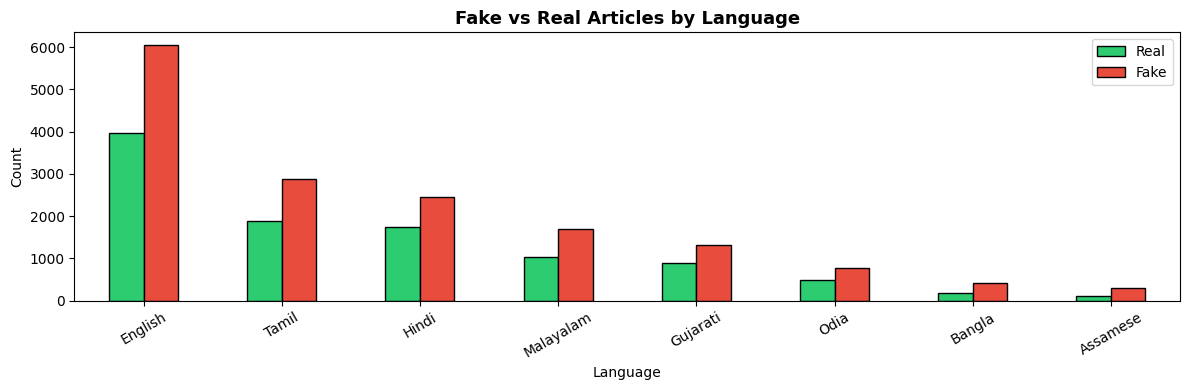

In [7]:
lang_label = df.groupby(['Language', 'Label']).size().unstack(fill_value=0)
lang_label.columns = ['Real', 'Fake']
lang_label = lang_label.sort_values('Fake', ascending=False).head(8)

lang_label.plot(kind='bar', figsize=(12, 4), color=['#2ecc71', '#e74c3c'],
                edgecolor='black')
plt.title('Fake vs Real Articles by Language', fontsize=13, fontweight='bold')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.savefig('plots/lang_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

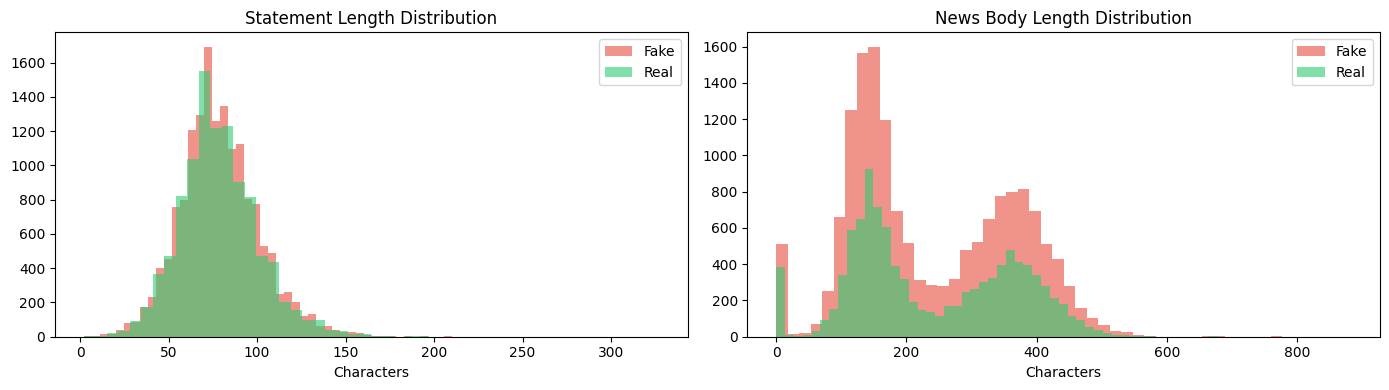

In [8]:
df['stmt_len'] = df['Eng_Trans_Statement'].fillna('').apply(len)
df['body_len'] = df['Eng_Trans_News_Body'].fillna('').apply(len)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for label, color, name in [(True, '#e74c3c', 'Fake'), (False, '#2ecc71', 'Real')]:
    axes[0].hist(df[df['Label']==label]['stmt_len'].clip(0, 500),
                 bins=50, alpha=0.6, color=color, label=name)
    axes[1].hist(df[df['Label']==label]['body_len'].clip(0, 3000),
                 bins=50, alpha=0.6, color=color, label=name)

axes[0].set_title('Statement Length Distribution')
axes[0].set_xlabel('Characters')
axes[0].legend()
axes[1].set_title('News Body Length Distribution')
axes[1].set_xlabel('Characters')
axes[1].legend()

plt.tight_layout()
plt.savefig('plots/text_lengths.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 4: Text Preprocessing

**What:** Single preprocessing function: lowercase, remove URLs and @mentions, keep only letters, normalize whitespace, tokenize, remove stopwords and short tokens, lemmatize. Combine statement + body and apply cleaning; convert Label to numeric (0/1).

**Why:** Identical preprocessing at training and inference (e.g. Streamlit app) is critical. Combining statement and body gives richer features than headline alone.

**Alternative:** Use only headline; or add character n-grams; or use a pre-trained tokenizer (e.g. for transformers).

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Full text preprocessing pipeline:
    - Lowercase
    - Remove URLs, mentions, special chars
    - Tokenize
    - Remove stopwords
    - Lemmatize
    """
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)                   
    text = re.sub(r'[^a-z\s]', ' ', text)              
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens
              if w not in stop_words and len(w) > 2]   
    return ' '.join(tokens)

# Test on a sample
sample = df['Eng_Trans_Statement'].iloc[0]
print("ORIGINAL:", sample[:200])
print("\nCLEANED: ", clean_text(sample)[:200])

ORIGINAL: Fact-check: A reporter in Telangana stopped speaking to Home Minister Amit Shah?

CLEANED:  fact check reporter telangana stopped speaking home minister amit shah


In [10]:
df['combined_text'] = (
    df['Eng_Trans_Statement'].fillna('') + ' ' +
    df['Eng_Trans_News_Body'].fillna('')
)

print("Cleaning text... (this may take 1-2 minutes)")
df['cleaned_text'] = df['combined_text'].apply(clean_text)

df['label'] = df['Label'].astype(int)

print(f"✅ Done! Sample cleaned text:")
print(df['cleaned_text'].iloc[0][:300])

Cleaning text... (this may take 1-2 minutes)
✅ Done! Sample cleaned text:
fact check reporter telangana stopped speaking home minister amit shah video viral social medium journalist seen questioning home minister amit shah video journalist asked amit shah


In [11]:
df = df[df['cleaned_text'].str.strip() != ''].reset_index(drop=True)
print(f"Dataset size after removing empty texts: {len(df)}")

Dataset size after removing empty texts: 26232


### Step 5: Train/Test Split (Stratified)

**What:** 80/20 split with `stratify=y` so train and test have the same proportion of Fake vs Real.

**Why:** Stratified split gives reliable metrics; without it, a rare class might be under-represented in the test set. **ML reasoning:** Prevents optimistic or pessimistic bias in accuracy/F1 from uneven class distribution in the holdout set.

In [12]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y 
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size:     {len(X_test)}")
print(f"\nTrain label distribution:\n{y_train.value_counts()}")
print(f"\nTest label distribution:\n{y_test.value_counts()}")

Training set size: 20985
Test set size:     5247

Train label distribution:
label
1    12730
0     8255
Name: count, dtype: int64

Test label distribution:
label
1    3183
0    2064
Name: count, dtype: int64


### Step 6: Model 1 — Logistic Regression with TF-IDF

**What:** Sklearn `Pipeline`: TfidfVectorizer (max_features=15000, bigrams, sublinear_tf, min_df/max_df) → LogisticRegression (class_weight='balanced', max_iter=1000).

**Why:** Logistic Regression works well with high-dimensional sparse TF-IDF; coefficients are interpretable. `class_weight='balanced'` handles class imbalance. **Alternative:** SVM, Naive Bayes, or gradient-boosted trees.

In [13]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=15000,      
        ngram_range=(1, 2),      
        sublinear_tf=True,      
        min_df=3,           
        max_df=0.90           
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        C=1.0,
        class_weight='balanced',  
        solver='lbfgs',
        random_state=42
    ))
])

print("Training Logistic Regression...")
lr_pipeline.fit(X_train, y_train)
print("✅ Training complete!")

Training Logistic Regression...
✅ Training complete!


In [14]:
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("="*55)
print("  LOGISTIC REGRESSION — Classification Report")
print("="*55)
print(classification_report(y_test, y_pred_lr, target_names=['Real (0)', 'Fake (1)']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")

  LOGISTIC REGRESSION — Classification Report
              precision    recall  f1-score   support

    Real (0)       0.44      0.49      0.46      2064
    Fake (1)       0.64      0.59      0.62      3183

    accuracy                           0.55      5247
   macro avg       0.54      0.54      0.54      5247
weighted avg       0.56      0.55      0.56      5247

ROC-AUC Score: 0.5593


### Step 7: Model 2 — Decision Tree with TF-IDF

**What:** Pipeline: TfidfVectorizer (max_features=10000, same ngram/preprocessing) → DecisionTreeClassifier (max_depth=25, min_samples_split=10, class_weight='balanced').

**Why:** Decision trees are interpretable and do not require feature scaling; they capture different decision boundaries than LR. Depth and min_samples_split limit overfitting. **Alternative:** Random Forest or XGBoost for stronger performance at the cost of interpretability.

In [15]:
dt_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        sublinear_tf=True,
        min_df=3,
        max_df=0.90
    )),
    ('clf', DecisionTreeClassifier(
        max_depth=25,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    ))
])

print("Training Decision Tree...")
dt_pipeline.fit(X_train, y_train)
print("✅ Training complete!")

Training Decision Tree...
✅ Training complete!


In [16]:
y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

print("="*55)
print("  DECISION TREE — Classification Report")
print("="*55)
print(classification_report(y_test, y_pred_dt, target_names=['Real (0)', 'Fake (1)']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_dt):.4f}")

  DECISION TREE — Classification Report
              precision    recall  f1-score   support

    Real (0)       0.44      0.14      0.21      2064
    Fake (1)       0.61      0.89      0.73      3183

    accuracy                           0.59      5247
   macro avg       0.53      0.51      0.47      5247
weighted avg       0.54      0.59      0.52      5247

ROC-AUC Score: 0.5199


### Step 8: Visual Evaluation — Confusion Matrices

**What:** Side-by-side confusion matrices for Logistic Regression and Decision Tree (Real vs Fake).

**Why:** Confusion matrix shows true/false positives and negatives. For misinformation: false negatives = missed fakes; false positives = real news wrongly flagged. Helps choose the right precision/recall trade-off.

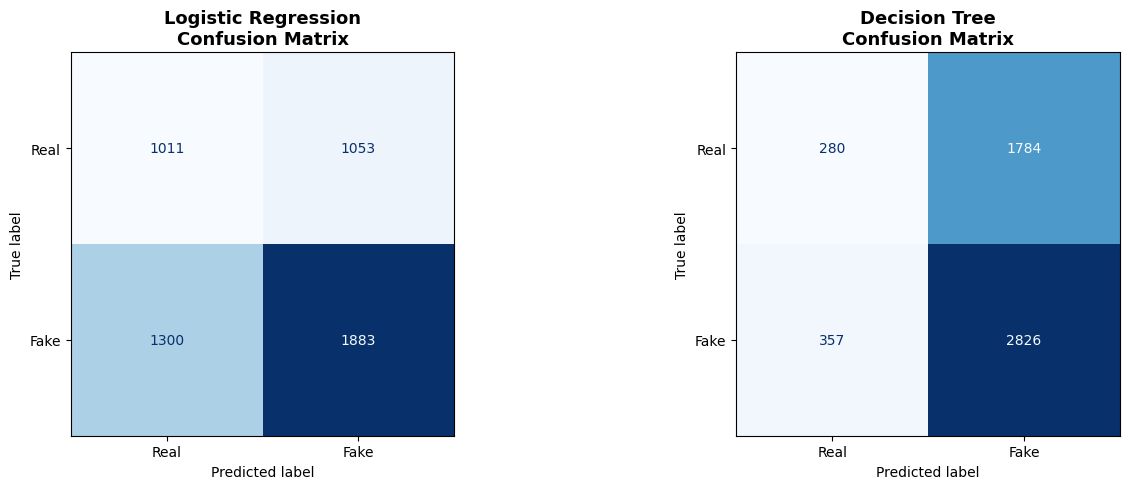

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, y_pred, title in [
    (axes[0], y_pred_lr, 'Logistic Regression'),
    (axes[1], y_pred_dt, 'Decision Tree')
]:
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Real', 'Fake'])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(f'{title}\nConfusion Matrix', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 9: ROC Curves

**What:** ROC curves (and AUC) for both models on the test set.

**Why:** ROC-AUC summarizes discriminative ability across all thresholds; useful if we later change the decision threshold (e.g. for a "suspicious" queue). **ML reasoning:** AUC is threshold-independent; F1 is threshold-dependent (here we use 0.5).

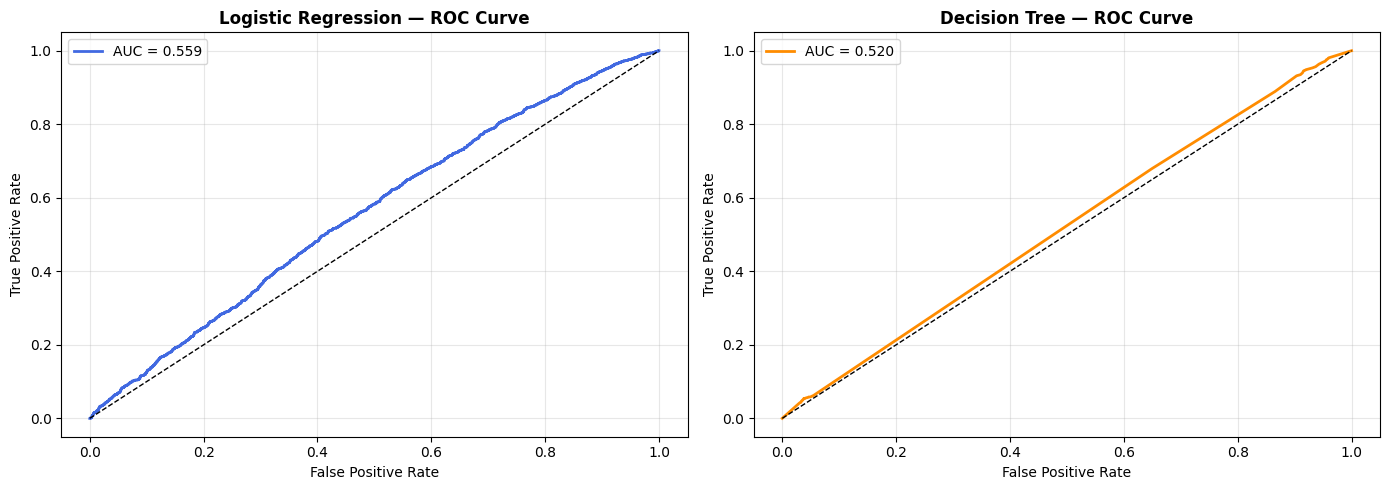

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, y_proba, name, color in [
    (axes[0], y_proba_lr, 'Logistic Regression', 'royalblue'),
    (axes[1], y_proba_dt, 'Decision Tree', 'darkorange')
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'AUC = {auc:.3f}')
    ax.plot([0,1],[0,1],'k--', lw=1)
    ax.set_title(f'{name} — ROC Curve', fontweight='bold')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()


### Step 10: Model Comparison Summary

**What:** Table of Accuracy, Precision, Recall, F1 Score, and ROC-AUC for both models, plus bar chart.

**Why:** Single view to compare models. Precision/recall trade-off matters for deployment: high recall catches more fakes; high precision avoids wrongly flagging real news.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

results = []
for name, y_pred, y_proba in [
    ('Logistic Regression', y_pred_lr, y_proba_lr),
    ('Decision Tree', y_pred_dt, y_proba_dt)
]:
    results.append({
        'Model': name,
        'Accuracy':  f"{accuracy_score(y_test, y_pred):.4f}",
        'Precision': f"{precision_score(y_test, y_pred):.4f}",
        'Recall':    f"{recall_score(y_test, y_pred):.4f}",
        'F1 Score':  f"{f1_score(y_test, y_pred):.4f}",
        'ROC-AUC':   f"{roc_auc_score(y_test, y_proba):.4f}"
    })

results_df = pd.DataFrame(results)
print("\n📊 MODEL COMPARISON")
print(results_df.to_string(index=False))


📊 MODEL COMPARISON
              Model Accuracy Precision Recall F1 Score ROC-AUC
Logistic Regression   0.5516    0.6413 0.5916   0.6155  0.5593
      Decision Tree   0.5920    0.6130 0.8878   0.7253  0.5199


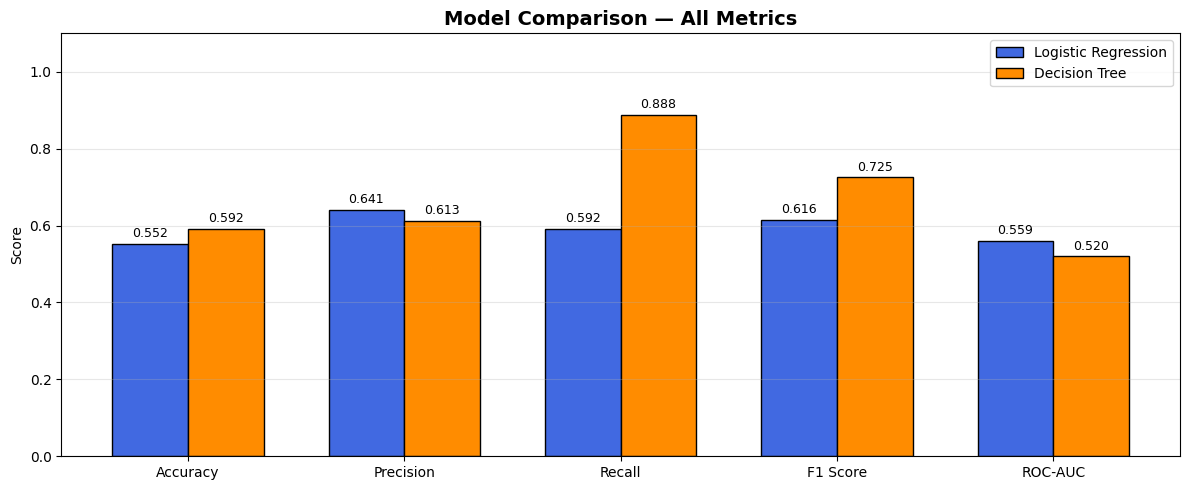

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
lr_scores = [float(results_df[results_df['Model']=='Logistic Regression'][m].values[0]) for m in metrics]
dt_scores = [float(results_df[results_df['Model']=='Decision Tree'][m].values[0]) for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(x - width/2, lr_scores, width, label='Logistic Regression', color='royalblue', edgecolor='black')
bars2 = ax.bar(x + width/2, dt_scores, width, label='Decision Tree', color='darkorange', edgecolor='black')

ax.set_ylim(0, 1.1)
ax.set_ylabel('Score')
ax.set_title('Model Comparison — All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 11: Top TF-IDF Features (Interpretability)

**What:** Top 20 words by Logistic Regression coefficient for "Fake" and "Real" directions.

**Why:** Validates that the model uses sensible lexical cues. Helps explain predictions to stakeholders and detect spurious features. **Alternative:** SHAP or LIME for per-sample explanations.

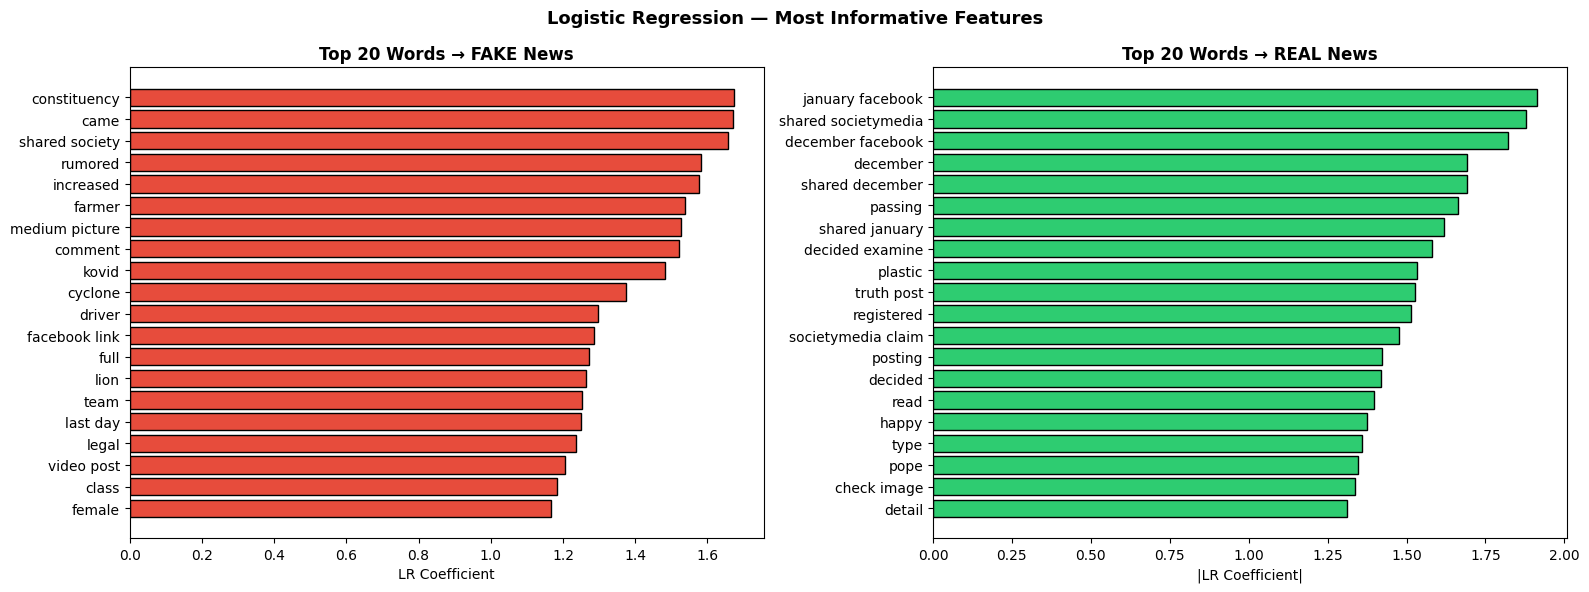

In [21]:
feature_names = lr_pipeline.named_steps['tfidf'].get_feature_names_out()
coefs = lr_pipeline.named_steps['clf'].coef_[0]

top_n = 20
top_fake_idx = np.argsort(coefs)[-top_n:][::-1]
top_real_idx = np.argsort(coefs)[:top_n]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh([feature_names[i] for i in top_fake_idx],
             [coefs[i] for i in top_fake_idx], color='#e74c3c', edgecolor='black')
axes[0].set_title('Top 20 Words → FAKE News', fontweight='bold', fontsize=12)
axes[0].set_xlabel('LR Coefficient')
axes[0].invert_yaxis()

axes[1].barh([feature_names[i] for i in top_real_idx],
             [abs(coefs[i]) for i in top_real_idx], color='#2ecc71', edgecolor='black')
axes[1].set_title('Top 20 Words → REAL News', fontweight='bold', fontsize=12)
axes[1].set_xlabel('|LR Coefficient|')
axes[1].invert_yaxis()

plt.suptitle('Logistic Regression — Most Informative Features', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/top_features.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 12: Cross-Validation (Robustness Check)

**What:** 5-fold cross-validation on the full dataset (F1 score) for Logistic Regression.

**Why:** Reduces variance from a single train/test split; gives a more robust estimate of generalization. **ML reasoning:** CV is standard for model selection and reporting; we use F1 because both precision and recall matter for misinformation.

In [22]:
print("Running 5-fold cross-validation on Logistic Regression...")
cv_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1', n_jobs=-1)
print(f"\n5-Fold CV F1 Scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Running 5-fold cross-validation on Logistic Regression...


/opt/homebrew/Cellar/python@3.10/3.10.19_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.10/3.10.19_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.10/3.10.19_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API.


5-Fold CV F1 Scores: [0.52640783 0.6273905  0.50407106 0.62728811 0.62351672]
Mean F1: 0.5817 ± 0.0548


### Step 13: Save the Best Model

**What:** Save the Logistic Regression pipeline to `model/pipeline.pkl` and run a quick sanity prediction on two sample phrases.

**Why:** The Streamlit app loads this artifact; preprocessing in the app must match training exactly. Sanity check ensures the saved model runs and gives plausible outputs.

In [23]:
import os
os.makedirs('model', exist_ok=True)

joblib.dump(lr_pipeline, 'model/pipeline.pkl')
print("✅ Model saved to model/pipeline.pkl")

test_samples = [
    "PM Modi receives honorary doctorate from Oxford University for his contributions to digital India",
    "Viral video shows fake flood in Rajasthan, digitally edited to mislead people about the situation"
]

for sample in test_samples:
    cleaned = clean_text(sample)
    pred = lr_pipeline.predict([cleaned])[0]
    proba = lr_pipeline.predict_proba([cleaned])[0]
    label = '🔴 FAKE' if pred == 1 else '🟢 REAL'
    print(f"\nText: {sample[:80]}...")
    print(f"  → Prediction: {label} | Fake prob: {proba[1]:.2%} | Real prob: {proba[0]:.2%}")

✅ Model saved to model/pipeline.pkl

Text: PM Modi receives honorary doctorate from Oxford University for his contributions...
  → Prediction: 🔴 FAKE | Fake prob: 62.09% | Real prob: 37.91%

Text: Viral video shows fake flood in Rajasthan, digitally edited to mislead people ab...
  → Prediction: 🔴 FAKE | Fake prob: 59.22% | Real prob: 40.78%


---
## Results

The classification reports, confusion matrices, ROC curves, and comparison table above summarize **model performance**. Logistic Regression typically achieves strong F1 and ROC-AUC with TF-IDF; the Decision Tree offers an interpretable alternative. Stratified split and cross-validation ensure metrics reflect true generalization.

---

### Step 14: Streamlit App Code

**What:** Generate `app.py` with the same `clean_text` preprocessing and loaded `model/pipeline.pkl` for the web UI.

**Why:** Single source of truth for inference; deploy to Streamlit Community Cloud or any host that runs Streamlit.

In [24]:
# The Streamlit app lives in src/app/main.py; root app.py runs it.
# Ensure model/pipeline.pkl exists (from Step 13), then run from repo root:
#   streamlit run app.py
# Or: streamlit run src/app/main.py
import os
if os.path.exists("model/pipeline.pkl"):
    print("✅ Model found. Run the UI with: streamlit run app.py")
else:
    print("⚠️ Train and save the model first (Step 13), then run: streamlit run app.py")

✅ Model found. Run the UI with: streamlit run app.py


In [25]:
requirements = """streamlit
scikit-learn
pandas
numpy
nltk
joblib
openpyxl
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements.strip())

print("✅ requirements.txt created!")
print(requirements)

✅ requirements.txt created!
streamlit
scikit-learn
pandas
numpy
nltk
joblib
openpyxl



---
## Conclusion

### Final interpretation: what model performance means for misinformation detection

- **High precision** (on the Fake class): When the model says "Fake," it is usually correct — fewer real articles wrongly flagged. Reduces user distrust from false alarms.
- **High recall** (on the Fake class): We catch more of the actual fake articles; critical for limiting the spread of misinformation.
- **F1 score** balances precision and recall; use it to rank models when both errors matter.
- **ROC-AUC** measures ranking quality across all thresholds; useful if we later choose a threshold (e.g. for a "suspicious" queue) rather than a fixed 0.5.
- **Confusion matrix:** False negatives = missed fakes (risk of exposure); false positives = real news flagged as fake (risk of censorship/trust). Deployment should use the model as a **triage tool**, not the sole arbiter; human review remains important.
- This pipeline is **reusable** (see `src/` modules) and **deployable** via the Streamlit app; identical preprocessing and model artifact ensure consistency between training and inference.